# Tutorial 11

### Today's Topic:
* RNN & LSTM
* VAE
* NERSC & Savio
* Data processing trick for ANI


## Recurrent Neural Network & LSTM

### RNN using a sin function to predict a cos funciton

/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


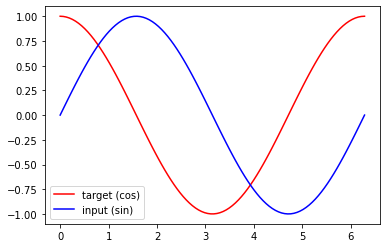

In [1]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt



# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)  # float32 for converting torch FloatTensor
x_np = np.sin(steps)
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [3]:
# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size= INPUT_SIZE, 
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        # outs (batch,time_step,1)
        outs = self.out(r_out)
        return outs, h_state

![](rnn.png)

In [4]:
rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

h_state = torch.zeros((1, 1, 32))     # for initial hidden state (input size, ?, hidden size )

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


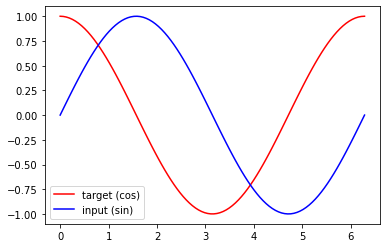

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [5]:
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)  # float32 for converting torch FloatTensor
x_np = np.sin(steps)
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()
plt.figure(1, figsize=(12, 5))

0


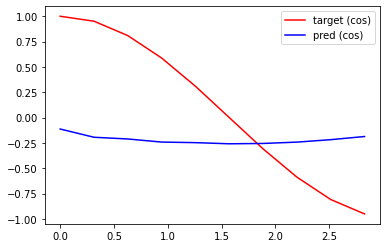

20


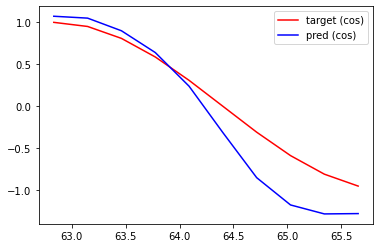

40


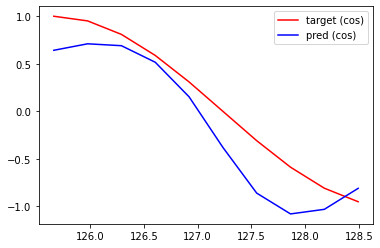

60


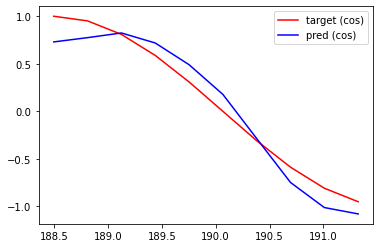

80


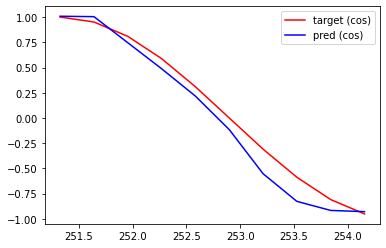

In [6]:
for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32, endpoint=False)  # float32 for converting torch FloatTensor
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn output
    # !! next step is important !!
    h_state = h_state.data        # repack the hidden state, break the connection from last iteration
#     # you can also do
#     h_state = h_state.detach()

    loss = loss_func(prediction, y)         # calculate loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients
    
    if step % 20 == 0:
        print(step)
        # plotting
        plt.plot(steps, y_np.flatten(), 'r-',label='target (cos)')
        plt.plot(steps, prediction.data.numpy().flatten(), 'b-',label='pred (cos)')
        plt.legend()
        plt.show()
        

### LSTM

LSTMs sounds a lot more complex than vanilla RNNs, but thanks to the magic of pytorch...<br>
![](lstm.png) <br>
Documentation: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [7]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.n_layers = 1
        self.n_hidden = 32

        self.lstm = nn.LSTM(
            input_size = INPUT_SIZE,
            hidden_size = self.n_hidden,
            num_layers = self.n_layers,
            batch_first = True, #(batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.lstm(x, h_state)
        outs = self.out(r_out)
        return outs, h_state
    
    def init_state(self, batchsize):
        return (torch.zeros(self.n_layers, batchsize, self.n_hidden), #hidden state
                torch.zeros(self.n_layers, batchsize, self.n_hidden)) #cell state

In [8]:
lstm = LSTM()
h_state, c_state = lstm.init_state(1)
print(lstm)


optimizer = torch.optim.Adam(lstm.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


0


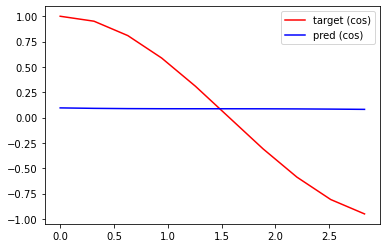

20


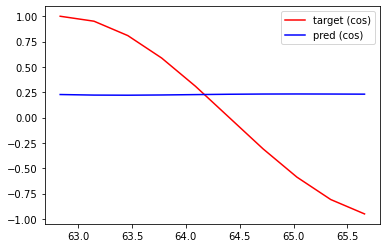

40


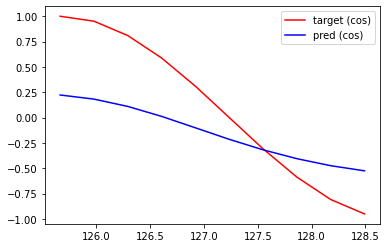

60


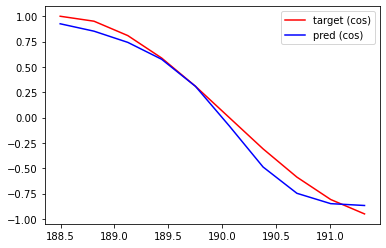

80


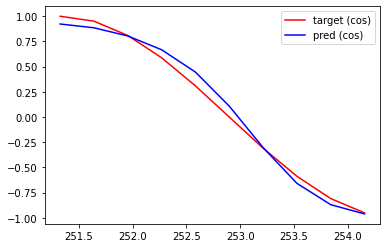

In [9]:
for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32, endpoint=False)  # float32 for converting torch FloatTensor
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, (h_state, c_state) = lstm(x, (h_state, c_state))   # rnn output
    # !! next step is important !!
#     h_state = h_state.data        # repack the hidden state, break the connection from last iteration
#     # you can also do
    h_state = h_state.detach()
    c_state = c_state.detach()

    loss = loss_func(prediction, y)         # calculate loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients
    
    if step % 20 == 0:
        print(step)
        # plotting
        plt.plot(steps, y_np.flatten(), 'r-',label='target (cos)')
        plt.plot(steps, prediction.data.numpy().flatten(), 'b-',label='pred (cos)')
        plt.legend()
        plt.show()
        

## Variational Auto Encoders

![](vae.png)

In [10]:
from torch import nn
import torch
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim) #mean
        self.fc32 = nn.Linear(h_dim2, z_dim) #variance
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def bottleneck(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps * std + mu # return z sampled
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        # go through the encoder to output mu 
        mu, log_var = self.encoder(x)
        z = self.bottleneck(mu, log_var)
        return self.decoder(z), mu, log_var



In [11]:
from torchsummary import summary
vae = VAE(64,64,32,16)
summary(vae)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            4,160
├─Linear: 1-2                            2,080
├─Linear: 1-3                            528
├─Linear: 1-4                            528
├─Linear: 1-5                            544
├─Linear: 1-6                            2,112
├─Linear: 1-7                            4,160
Total params: 14,112
Trainable params: 14,112
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            4,160
├─Linear: 1-2                            2,080
├─Linear: 1-3                            528
├─Linear: 1-4                            528
├─Linear: 1-5                            544
├─Linear: 1-6                            2,112
├─Linear: 1-7                            4,160
Total params: 14,112
Trainable params: 14,112
Non-trainable params: 0

### Reparameterization

![](reparameterization_trick.png)

### VAE with CNN
Transposed convolution: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [12]:
class VAE_CNN(nn.Module):
    def __init__(self, image_channels, h_dim, z_dim):
        super(VAE_CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 4, kernel_size=4, stride=2, padding=1), #16
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.unflatten = lambda x: x.view(-1,32,2,2)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        # return torch.normal(mu, std)
        epsilon = torch.randn_like(std)
        z = mu + std * epsilon
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.unflatten(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

### Loss function
The Kullback-Leibler divergence ( KL divergence) is a measure of how a probability distribution differs from another probability distribution. When KL divergence=0, two distribution are the same. 
The purpose of the KL divergence term in the loss function is to make the distribution of the encoder output as close as possible to a standard multivariate normal distribution.

In [13]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

## NERSC and Savio cluster resources


https://ood.brc.berkeley.edu/

## Data processing trick for ANI

In [ ]:
for i in range(n_epochs):
    for d in h5files:
        for mol in d:
            species = ...
            # Do train test split here on coords
            ...
            train_gen = data_gen(train_Xs, train_ys,species) #compute AEVs (N, A, num_aev)
            for train_X,train_y in train_gen:
                # train on one batch
                ...
            #validation here
            
#test here after training finished
            
            
                
            